In [15]:
# G Oldford Jan 10 2022
# Opens a series of ASC files created by R (Esri style ASC)
# clips
# re-normalize (sum to 1)
# export for Ecospace ASC (header for ASC different than Esri)
import os
import pandas as pd
import numpy as np

year_start = 1966
year_end = 2014

#path = "C://Users//Greig//Documents//GitHub//Ecosystem-Model-Data-Framework//notebooks//"
path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//2. Seals//_MODEL_seal_HabCap//"
f_in_template = "sealforagingintens1{}.asc"
#f_out_template = "sealforagingintensEWE4{}.asc" # use this if annual
f_out_template = "sealforagingintensEWE4{}-{}.asc" # use this if monthly


# the rows indices are reversed because they were originally for working 
# with NEMO netCDF which indexes starting at zero in the bottom left
#NEMO_row_count = 299 #zero-indexed! row count 299
#NEMO_col_count = 133 #zeroindex 
#upperleft_row_NEMOindex = 253 # the cell in NEMO index convention where clipping for EwE
#bottomleft_row_NEMOindex = 102
#upper_row_reversed = NEMO_rows - upperleft_row_ewe
#bottom_row_reversed = NEMO_rows - bottomleft_row_NEMOindex

header_length = 6
upperleft_col_ewe = 39 # here we keep all cols to the right during clip
bottomleft_col_ewe = 39
upperrow_ewe = 47 # 1-based indexing in EwE 
lowerrow_ewe = 197
xllcorner = -123.80739
yllcorner = 48.29471

headerlines = []
headerlines.append(["ncols        93"])
headerlines.append(["nrows        151"])
headerlines.append(["xllcorner    " + str(xllcorner)])
headerlines.append(["yllcorner    " + str(yllcorner)])
headerlines.append(["cellsize      0.013497347"])
headerlines.append(["NODATA_value  0.0"])

#Create mask from Ecospace basemap (some land cells used in seal analysis)
EwEBasemap_f = "ecospacedepthgrid.asc"
EwEdir = "C://Users//Greig//Documents//GitHub//Ecosystem-Model-Data-Framework//data//basemap//"
MaskFilename = os.path.join(EwEdir, EwEBasemap_f)
# two step process could be shortened (using template code from JB for opening file)
dfMask = pd.read_table(MaskFilename, skiprows=6, header=None, delim_whitespace=True,na_values=0)
npMask = dfMask.to_numpy()
npMask[npMask > 0] = 1


for y in range(year_start, year_end + 1):
    print(y)
    maprows = []
    f = open(path + f_in_template.format(y), "r")
    x = 1
    for row in f:
        if (x >= upperrow_ewe + header_length) & (x <= lowerrow_ewe + header_length): 
            # must convert to numeric to keep
            row_nolb = row.strip() #removes /n from last element
            row_list = row_nolb.split(' ') # create array (string)
            maprows.append(row_list[upperleft_col_ewe:])
        x += 1
    f.close()
    
    # apply mask
    np_maprows = np.asarray(maprows)
    np_maprows_flt = np_maprows.astype(np.float)
    np_maprows_msk = np_maprows_flt * npMask
    
    # normalize to one (not the usual way - so all map cells sum to 1). 
    #    this way, biomasses can be cross-checked easily
    np_maprows_sum1 = (np_maprows_msk - np.nanmin(np_maprows_msk)) / np.nansum(np_maprows_msk - np.nanmin(np_maprows_msk))
    #np.nansum(np_maprows_sum1) #now equals one
    np_maprows_sum1_nonan = np.nan_to_num(np_maprows_sum1)
    
    # added this Jan 12 2022 - GO
    # rescale again - the number ecospace expects is a weighting relative to expected biomass in a cell:
    # B_cell = B_tot * (1 / n_cells) * W
    # since number in each cell for maps prepped here is a proportion (sums to one) it can be written: 
    # B_cell = B_tot * P
    # If assuming homongenous distribution and B's the same in each cell then P = 1 / n_cells --> 
    # B_cell = B_tot * 1 / n_cells
    # If P's vary in cells, we can adjust based on the expected value
    # B_cell = B_tot * P / (1 / n_cells)
    #        = B_tot * P * n_cells
    # all to say I'll multiply by the number of non-land cells in the map. 
    land_cell_count = np.count_nonzero(~np.isnan(npMask))
    np_maprows_ewe = np_maprows_sum1_nonan * land_cell_count
    
    # ugh - the 'habitat model' (not hab capac) in EwE only allows values from 0 - 1
    # who knows what's going on behind the curtain of the Wizard of Oz
    max_val = np.nanmax(np_maprows_ewe)
    np_maprows_ewe2 = np_maprows_ewe / max_val  
    
    
    # ugh ecospace isn't working with annual driver data
    #with open(path + f_out_template.format(y),'w',encoding = 'utf-8') as f2:
    #    for h in headerlines: 
    #        f2.write(h[0])
    #        f2.write("\n")
    #    for n in np_maprows_ewe2: 
    #        a_str = ' '.join(str(x) for x in n) # '0,3,5'
    #        f2.write(a_str)
    #        f2.write("\n")
    #f2.close()
    
    for m in range(1,13):
        print(m)
        with open(path + f_out_template.format(y,m),'w',encoding = 'utf-8') as f2:
            for h in headerlines: 
                f2.write(h[0])
                f2.write("\n")
            for n in np_maprows_ewe2: 
                a_str = ' '.join(str(x) for x in n) # '0,3,5'
                f2.write(a_str)
                f2.write("\n")
        f2.close()
    

C:\Users\Greig\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
C:\Users\Greig\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


1966
1
2
3
4
5
6
7
8
9
10
11
12
1967
1
2
3
4
5
6
7
8
9
10
11
12
1968
1
2
3
4
5
6
7
8
9
10
11
12
1969
1
2
3
4
5
6
7
8
9
10
11
12
1970
1
2
3
4
5
6
7
8
9
10
11
12
1971
1
2
3
4
5
6
7
8
9
10
11
12
1972
1
2
3
4
5
6
7
8
9
10
11
12
1973
1
2
3
4
5
6
7
8
9
10
11
12
1974
1
2
3
4
5
6
7
8
9
10
11
12
1975
1
2
3
4
5
6
7
8
9
10
11
12
1976
1
2
3
4
5
6
7
8
9
10
11
12
1977
1
2
3
4
5
6
7
8
9
10
11
12
1978
1
2
3
4
5
6
7
8
9
10
11
12
1979
1
2
3
4
5
6
7
8
9
10
11
12
1980
1
2
3
4
5
6
7
8
9
10
11
12
1981
1
2
3
4
5
6
7
8
9
10
11
12
1982
1
2
3
4
5
6
7
8
9
10
11
12
1983
1
2
3
4
5
6
7
8
9
10
11
12
1984
1
2
3
4
5
6
7
8
9
10
11
12
1985
1
2
3
4
5
6
7
8
9
10
11
12
1986
1
2
3
4
5
6
7
8
9
10
11
12
1987
1
2
3
4
5
6
7
8
9
10
11
12
1988
1
2
3
4
5
6
7
8
9
10
11
12
1989
1
2
3
4
5
6
7
8
9
10
11
12
1990
1
2
3
4
5
6
7
8
9
10
11
12
1991
1
2
3
4
5
6
7
8
9
10
11
12
1992
1
2
3
4
5
6
7
8
9
10
11
12
1993
1
2
3
4
5
6
7
8
9
10
11
12
1994
1
2
3
4
5
6
7
8
9
10
11
12
1995
1
2
3
4
5
6
7
8
9
10
11
12
1996
1
2
3
4
5
6
7
8
9
10
11
12
1997
1
2

1
2
3
4
5
6
7
8
9
10
11


## Just cross-checks and junk code below

In [166]:
np_maprows_sum1 = (np_maprows_msk - np.nanmin(np_maprows_msk)) / np.nansum(np_maprows_msk - np.nanmin(np_maprows_msk))
np.nansum(np_maprows_sum1) #now equals one
np_maprows_sum1_nonan = np.nan_to_num(np_maprows_sum1)

for n in np_maprows_sum1_nonan:
    a_str = ' '.join(str(x) for x in n)
a_str


'3.837380618884385e-05 4.112829551177406e-05 5.01454850378995e-05 5.302323666199985e-05 5.3115689301163256e-05 5.810699315907747e-05 6.198835517777505e-05 6.20950312934024e-05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0001672234477109425 0.0001651399214058236 0.00016428901267855655 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0002745205632856521 0.00028605301480249786 0.00028493713303824955 0.00029230103011642917 0.0002829610275671579 0.00028273685506449063 0.00027909325120008217 0.0002854899642993201 0.0002773093626065803 0.0002814907725565376 0.00026228922730406427 0.0 0.0 0.0 0.0 0.0 0.00030384222387893657 0.00032287954869984157 0.0003139956027459244 0.00031874861392248207 0.00029544918120422484 0.00027574846273174835 0.0 0.0 0.0 0.0 0.0 0.000239201192237328 0.0 0.0 0.0 0.0 0.0 0.00023123462756319914 0.0002286250753462878 0.0002277828750116298 0.00022604068350181995 0.00021271986310894827 0.00020148945140045934 0.0 0.00016913601750554946 0.00015566481780920856 0.000150742633317

In [175]:
np_maprows_sum1_nonan

array([[0.00000000e+00, 0.00000000e+00, 9.35041833e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.09262805e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.02885155e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.79279888e-05, 4.08093935e-05, 4.35422539e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.08093935e-05, 4.35422539e-05, 4.36231500e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.83738062e-05, 4.11282955e-05, 5.01454850e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [145]:
np.sum(np.linalg.norm(np_maprows_flt))

0.011658572282688899

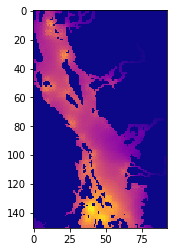

In [6]:
# check out glumpy for animations

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np_maprows_ewe)
#plt.gray()
plt.plasma()
plt.show()

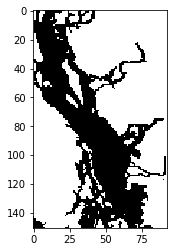

In [130]:
test_masked = np_maprows_flt * npMask
plt.imshow(np_maprows_flt - test_masked)
plt.gray()
plt.show()

In [153]:
np_maprows_msk - np.nanmin(np_maprows_msk)

array([[           nan,            nan, 7.18837516e-05, ...,
                   nan,            nan,            nan],
       [           nan,            nan, 8.39985984e-05, ...,
                   nan,            nan,            nan],
       [           nan,            nan, 7.90956158e-05, ...,
                   nan,            nan,            nan],
       ...,
       [2.91581192e-05, 3.13732734e-05, 3.34742303e-05, ...,
                   nan,            nan,            nan],
       [3.13732734e-05, 3.34742303e-05, 3.35364212e-05, ...,
                   nan,            nan,            nan],
       [2.95008529e-05, 3.16184375e-05, 3.85506345e-05, ...,
                   nan,            nan,            nan]])

In [141]:
np.nanmax(np_maprows_flt - test_masked) # if zero good

0.0

In [34]:
# the numpy way below doesn't work because the rows are strings
import numpy as np
ASCheader = "ncols        93\nnrows        151 \nxllcorner    -123.80739\nyllcorner    48.29471 \ncellsize     0.013497347 \nNODATA_value  0.0"
fout = path + f_out_template.format(y)
np.savetxt(f_out_template.format(y), maprows, fmt='%0.5f', delimiter=" ", comments='',header=ASCheader)

TypeError: Mismatch between array dtype ('<U1135') and format specifier ('%0.5f')

In [31]:
fout = path + f_out_template.format(y)
fout

'C://Users//Greig//Documents//GitHub//Ecosystem-Model-Data-Framework//notebooks//sealforagingintensEWE1966.asc'

'0'

In [20]:
row[upperleft_col_ewe:]

' 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n'

In [21]:
row[:]

'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n'